CLASIFICACIÓN CANCER DE MAMA CON EL MODELO CNN
K-FOLD

In [1]:
import tensorflow as tf
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
import warnings 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
import imblearn
from imblearn.over_sampling import RandomOverSampler
warnings.filterwarnings('ignore')                    # Turn the warnings off.
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

Using TensorFlow backend.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
os.chdir('C:\\Users\\Indiaka.TORRE-DAVID\\Desktop\Datos')

In [4]:
#os.chdir('/content/drive/MyDrive/Datos')

In [5]:
BC_df_copy = pd.read_csv('C:\\Users\\Indiaka.TORRE-DAVID\\Desktop\Datos\\Breat_cancer_data.csv')
BC_df_copy.head()

,Unnamed: 0,patient_ID,pathes,diagnosis
0,0,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0
1,1,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0
2,2,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0
3,3,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0
4,4,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0


In [6]:
BC_df_copy = BC_df_copy.sort_values('patient_ID')

In [7]:
BC_df_copy.iloc[1400:1401,:]

,Unnamed: 0,patient_ID,pathes,diagnosis
1580,1580,10255,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,1


In [8]:
from PIL.Image import open
BC_df_copy['pixels'] =  BC_df_copy['pathes'].map(lambda x:np.asarray(open(x).resize((224,224))))

In [9]:
BC_df_copy.head()

,Unnamed: 0,patient_ID,pathes,diagnosis,pixels
0,0,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0,"[[[227, 168, 209], [227, 168, 209], [227, 167,..."
375,375,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0,"[[[161, 98, 123], [164, 101, 125], [168, 108, ..."
374,374,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0,"[[[225, 181, 207], [225, 180, 206], [225, 176,..."
373,373,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0,"[[[249, 245, 252], [249, 245, 252], [249, 245,..."
372,372,10253,C:\Users\Indiaka.TORRE-DAVID\Desktop\Datos\can...,0,"[[[226, 197, 221], [227, 198, 221], [227, 201,..."


In [10]:
BC_df_copy['diagnosisPaciente'] = BC_df_copy['diagnosis'].map(str) + "_" + BC_df_copy['patient_ID'].map(str)

**CREACIÓN DE LOS CONJUNTOS DE DATOS**

In [11]:
X = BC_df_copy['pixels']
y = np.array(BC_df_copy['diagnosis'])

In [12]:
X_train = X[0:1397]
X_validation = X[1397:1669]
X_test = X[1669:2137]
y_train =BC_df_copy['diagnosisPaciente'][0:1397]
y_validation = y[1397:1669]
y_test = y[1669:2137]
C_validation = BC_df_copy['patient_ID'][1397:1669]

print('La dimension de X_train :'+" "+str(X_train.shape))
print('La dimension de X_validation :'+" "+str(X_validation.shape))
print('La dimension de X_test :'+" "+str(X_test.shape))
print('La dimension de y_train :'+" "+str(y_train.shape))
print('La dimension de y_validation :'+" "+str(y_validation.shape))
print('La dimension de y_test :'+" "+str(y_test.shape))

La dimension de X_train : (1397,)
La dimension de X_validation : (272,)
La dimension de X_test : (468,)
La dimension de y_train : (1397,)
La dimension de y_validation : (272,)
La dimension de y_test : (468,)


In [13]:
#información relevante
num_train = len((X_train))
num_test = len((X_test))
num_classes = 2

# Print important info
print(f'Numero de imágenes para train: {num_train} \
        \nNumero de imágenes para test: {num_test} \
        \nNumero de clases: {num_classes}')

Numero de imágenes para train: 1397         
Numero de imágenes para test: 468         
Numero de clases: 2


In [14]:
# training set
img_list = []
for i in range (0,len(X_train)):
    brain_img =np.array(X_train)[i]
    img_arr = img_to_array(brain_img/255).astype(np.float32)
    img_list.append(img_arr)
X_scaled = np.array(img_list)

print(X_scaled.shape)

(1397, 224, 224, 3)


In [15]:
# validation set
img_validation = []
for i in range (0,len(X_validation)):
    brain_img_validation =np.array(X_validation)[i]
    img_validation_arr = img_to_array(brain_img_validation/255).astype(np.float32)
    img_validation.append((img_validation_arr))
X_scaled_validation = np.array(img_validation)

print(X_scaled_validation.shape)

(272, 224, 224, 3)


In [16]:
# test set
img_test = []
for i in range (0,len(X_test)):
    brain_img_test =np.array(X_test)[i]
    img_test_arr = img_to_array(brain_img_test/255).astype(np.float32)
    img_test.append((img_test_arr))
X_scaled_test = np.array(img_test)

print(X_scaled_test.shape)

(468, 224, 224, 3)


****Balanceo de datos para el train set****

In [17]:
X_train_shape = X_scaled.shape[1]*X_scaled.shape[2]*X_scaled.shape[3]
X_Flatten = X_scaled.reshape(X_scaled.shape[0],X_train_shape)

In [18]:
ros = RandomOverSampler(random_state=10)
X_train_res, y_train = ros.fit_resample(X_Flatten, y_train)

In [19]:
row,col,channel = 224 ,224 , 3 
X_scaled = X_train_res.reshape(len(X_train_res),row,col,channel)
# chec the shape of our training set
print('The shape of the training set after reshape it :'+" "+str(X_scaled.shape))

The shape of the training set after reshape it : (3088, 224, 224, 3)


Separar los campos en diagnosis y codigo paciente

In [20]:
C_train = y_train.str.split("_",1).str[1]

In [21]:
y_train = y_train.str.split("_",1).str[0]

In [22]:
C_validation.shape

(272,)

Unir los conjuntos de train y validation para hacer posteriormente el k-fold

In [23]:
C_total = np.concatenate((C_train,C_validation), axis =0)

In [24]:
y_train = np.concatenate((y_train,y_validation), axis =0)

In [25]:
X_scaled = np.concatenate((X_scaled,X_scaled_validation), axis = 0)

**one-hot-encoding**

In [26]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
print(y_train.shape)
print(y_test.shape)

(3360, 2)
(468, 2)


In [27]:
C_total = np.array(C_total).astype(int)

**CREACIÓN y ENTRENAMIENTO DEL MODELO**

In [29]:
from sklearn.model_selection import GroupKFold

In [30]:
n_epochs = 2
batch_size = 32
learn_rate = 0.0002

In [31]:
drop_prob = 0.5
my_model = Sequential()
# 1st convolution + pooling.
my_model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(5,5),padding='same',activation="relu"))        # 3 channels of color.
my_model.add(MaxPooling2D(pool_size=2))
# 2nd convolution + pooling.
my_model.add(Conv2D(filters=64,kernel_size=(5,5), padding='same',activation="relu"))
my_model.add(MaxPooling2D(pool_size=2))
# Flattened fully connected layer.
my_model.add(Flatten())
my_model.add(Dense(units = 1024, activation="relu"))
# Apply dropout.
my_model.add(Dropout(rate=drop_prob))
# Output layer.
my_model.add(Dense(units = 2, activation="softmax"))

In [32]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              205521920 
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [33]:
my_optimizer=Adam(lr=learn_rate)
my_model.compile(loss = "categorical_crossentropy", optimizer = my_optimizer, metrics=["accuracy"])

In [34]:
groups = C_total
group_kfold = GroupKFold(n_splits= 3)
cvscores = []
for train,validacion  in group_kfold.split(X_scaled,y_train, groups):
  historia = my_model.fit(X_scaled[train],y_train[train], epochs=n_epochs, batch_size = batch_size, verbose = 2)
  resTest = my_model.evaluate(X_scaled[validacion], y_train[validacion], verbose = 0)
  print("%s: %.2f%%" % (my_model.metrics_names[1], resTest[1]*100))
  cvscores.append(resTest[1]*100)
  print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

Train on 1816 samples
Epoch 1/2
1816/1816 - 86s - loss: 0.6988 - accuracy: 0.8150
Epoch 2/2
1816/1816 - 87s - loss: 0.1285 - accuracy: 0.9548
accuracy: 84.52%
84.52% (+/- 0.00%)
Train on 1816 samples
Epoch 1/2
1816/1816 - 86s - loss: 0.2677 - accuracy: 0.8981
Epoch 2/2
1816/1816 - 88s - loss: 0.1334 - accuracy: 0.9593
accuracy: 75.97%
80.25% (+/- 4.27%)
Train on 3088 samples
Epoch 1/2
3088/3088 - 148s - loss: 0.1101 - accuracy: 0.9631
Epoch 2/2
3088/3088 - 148s - loss: 0.0331 - accuracy: 0.9945
accuracy: 84.56%
81.68% (+/- 4.04%)


In [38]:
historia.history.keys()

dict_keys(['loss', 'accuracy'])

**GRÁFICAS. Evaluación de los resultados con el conjunto de validación**

In [39]:
accuracy_validation = historia.history['accuracy'][-1]
accuracy_validation

0.9944948

In [43]:
resTest

[0.47149830952505856, 0.8455882]

KeyError: 'val_accuracy'

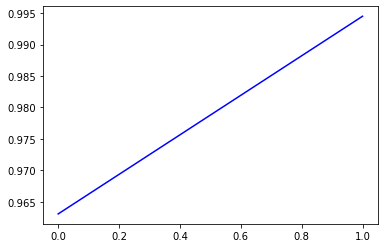

In [40]:
# Gráfica para visualizar el resultado del entrenamiento del modelo. 
n_skip = 0                 # Skip the first few steps.
plt.plot(historia.history['accuracy'][n_skip:], c="b")
plt.plot(historia.history['val_accuracy'][n_skip:], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

**MÉTRICAS. Evaluación de los resultados con el conjunto de test**

In [44]:
from sklearn.metrics import classification_report , confusion_matrix, multilabel_confusion_matrix

In [48]:
y_pred = my_model.predict(X_scaled_test)
y_pred = np.round(y_pred).astype(int)

In [49]:
target_name = ['benigno','maligno']
classification_report(y_true=y_test , y_pred=y_pred , output_dict=True , target_names= target_name )

{'benigno': {'precision': 0.9347826086956522,
  'recall': 0.98005698005698,
  'f1-score': 0.9568845618915162,
  'support': 351},
 'maligno': {'precision': 0.93,
  'recall': 0.7948717948717948,
  'f1-score': 0.8571428571428572,
  'support': 117},
 'micro avg': {'precision': 0.9337606837606838,
  'recall': 0.9337606837606838,
  'f1-score': 0.9337606837606838,
  'support': 468},
 'macro avg': {'precision': 0.9323913043478261,
  'recall': 0.8874643874643875,
  'f1-score': 0.9070137095171866,
  'support': 468},
 'weighted avg': {'precision': 0.9335869565217392,
  'recall': 0.9337606837606838,
  'f1-score': 0.9319491357043513,
  'support': 468},
 'samples avg': {'precision': 0.9337606837606838,
  'recall': 0.9337606837606838,
  'f1-score': 0.9337606837606838,
  'support': 468}}

**matriz de confusión**

In [51]:
multilabel_confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[[ 93,  24],
        [  7, 344]],

       [[344,   7],
        [ 24,  93]]], dtype=int64)